Produce data

In [3]:
import random
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('preprocessed_Limonene_data.csv', index_col=0)
df.head(3)

,Limonene,MVD1_YEAST,Q40322_MENSP,IDI_ECOLI,ATOB_ECOLI,Q8LKJ3_ABIGR,Q9FD87_STAAU,Q9FD86_STAAU,KIME_YEAST,ERG8_YEAST
B.Mm,35.29984,1.5997,5.59030,2.13160,0.3823,0.55800,1.13830,0.90780,0.3720,0.69690
A.Ml,15.33663,1.8479,4.03260,2.05450,1.2792,0.47690,4.09220,3.71690,0.2986,0.76480
BL.Mm,119.81367,3.1930,11.31405,2.29065,1.2554,1.63235,0.41045,0.25975,1.0486,0.58985


ML-based optimization

In [5]:
# import the necessary packages
import matplotlib.pyplot as plt
import pandas as pd
import pyomo.environ as pyo
import tensorflow.keras as keras
from omlt import OffsetScaling, OmltBlock
from omlt.io.keras import load_keras_sequential
from omlt.neuralnet import FullSpaceSmoothNNFormulation
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


In [8]:
def loss_curve(history):
    plt.figure(figsize=(10,2))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.title('Loss Curve')
    plt.show()

inputs = df.drop(columns=['Limonene']).columns.values.tolist()
outputs = ['Limonene']

In [9]:
# We scale the data for improved training, however, we want to formulate
# our optimizaton problem on the original variables. Therefore, we keep
# the scaling parameters to use later in our optimization formulation
dfin = df[inputs]
dfout = df[outputs]

x_offset, x_factor = dfin.mean().to_dict(), dfin.std().to_dict()
y_offset, y_factor = dfout.mean().to_dict(), dfout.std().to_dict()

dfin = (dfin - dfin.mean()).divide(dfin.std())
dfout = (dfout - dfout.mean()).divide(dfout.std())

# capture the minimum and maximum values of the scaled inputs
# so we don't use the model outside the valid range
scaled_lb = dfin.min()[inputs].values
scaled_ub = dfin.max()[inputs].values

x = dfin[inputs].values
y = dfout[outputs].values

Epoch 1/100
1/1 - 1s - loss: 1.4500 - val_loss: 1.8898 - 716ms/epoch - 716ms/step
Epoch 2/100
1/1 - 0s - loss: 1.3962 - val_loss: 1.8261 - 54ms/epoch - 54ms/step
Epoch 3/100
1/1 - 0s - loss: 1.3454 - val_loss: 1.7655 - 46ms/epoch - 46ms/step
Epoch 4/100
1/1 - 0s - loss: 1.2978 - val_loss: 1.7080 - 29ms/epoch - 29ms/step
Epoch 5/100
1/1 - 0s - loss: 1.2534 - val_loss: 1.6537 - 53ms/epoch - 53ms/step
Epoch 6/100
1/1 - 0s - loss: 1.2120 - val_loss: 1.6025 - 46ms/epoch - 46ms/step
Epoch 7/100
1/1 - 0s - loss: 1.1737 - val_loss: 1.5545 - 80ms/epoch - 80ms/step
Epoch 8/100
1/1 - 0s - loss: 1.1382 - val_loss: 1.5095 - 49ms/epoch - 49ms/step
Epoch 9/100
1/1 - 0s - loss: 1.1054 - val_loss: 1.4673 - 45ms/epoch - 45ms/step
Epoch 10/100
1/1 - 0s - loss: 1.0750 - val_loss: 1.4278 - 38ms/epoch - 38ms/step
Epoch 11/100
1/1 - 0s - loss: 1.0466 - val_loss: 1.3908 - 54ms/epoch - 54ms/step
Epoch 12/100
1/1 - 0s - loss: 1.0200 - val_loss: 1.3561 - 50ms/epoch - 50ms/step
Epoch 13/100
1/1 - 0s - loss: 0.994

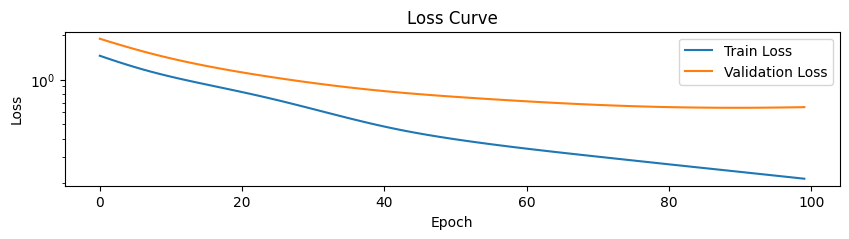

In [12]:
# Create a simple ANN using Keras
model = Sequential()
model.add(Dense(3, input_dim=x.shape[1], activation='sigmoid'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.01))
history = model.fit(x, y, epochs=100, batch_size=512, validation_split=.33, verbose=2)

# save the model to disk
model.save('reformer_nn.keras')

# Plot loss curve
loss_curve(history)

In [13]:
m = pyo.ConcreteModel()
m.reformer = OmltBlock()
nn_reformer = keras.models.load_model('reformer_nn.keras', compile=False)

scaler = OffsetScaling(
        offset_inputs={i: x_offset[inputs[i]] for i in range(len(inputs))},
        factor_inputs={i: x_factor[inputs[i]] for i in range(len(inputs))},
        offset_outputs={i: y_offset[outputs[i]] for i in range(len(outputs))},
        factor_outputs={i: y_factor[outputs[i]] for i in range(len(outputs))}
    )

scaled_input_bounds = {i: (scaled_lb[i], scaled_ub[i]) for i in range(len(inputs))}

net = load_keras_sequential(nn_reformer, scaling_object=scaler, scaled_input_bounds=scaled_input_bounds) 
m.reformer.build_formulation(FullSpaceSmoothNNFormulation(net))

In [16]:
# Add objective and constraints
m.obj = pyo.Objective(expr=m.reformer.outputs[0], sense=pyo.maximize)

# Solve
solver = pyo.SolverFactory('ipopt')
status = solver.solve(m, tee=True)

print(f"Objective value: {pyo.value(m.obj)}")
for i in range(len(inputs)):
    print(f"{inputs[i]}: {pyo.value(m.reformer.inputs[i])}")

'pyomo.core.base.objective.ScalarObjective'>) on block unknown with a new
Component (type=<class 'pyomo.core.base.objective.ScalarObjective'>). This is
usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().
Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:       82
Number of nonzeros in inequality constraint Jacobian